In [15]:
#这个代码绘制的是神经网络的混沌热图，对应第二个Phase_diagram文件夹中的文件，做了一些修改

In [16]:

#这个模块可以用来读取、写入或更改文件的目录，或者获取操作系统的信息，包含了很多与操作系统交互的函数
import os 
#这个模块用于序列化和反序列化 Python 对象结构，也称为封装和解封装。
#序列化是将 Python 对象转换为字节流的过程，以便可以将其存储到磁盘上，或者通过网络传输到远程位置。反序列化是将这个字节流转换回原始 Python 对象的过程。
import pickle


import argparse #argparse是用来处理命令行参数的工具，提供了一种方便的方式来定义用户应该如何指定/处理这些参数
import time


import matplotlib.pyplot as plt
import numpy as np
#下面的`scipy`是一个用于科学计算和技术计算的Python库，提供了许多高级的数学函数和便利的操作，包括数值积分、插值、优化、图像处理、统计等。
import scipy.io as spio #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）。
import seaborn as sns #seaborn是一个基于matplotlib的python数据可视化库，提供了一种高级接口，用于绘制有吸引力切信息丰富的统计图形。
#matplotlib.lines是python数据可视化库matplotlib中一个模块，包含了一些用于创建和操作线条对象的类和函数
#Line2D是该模块中一个类，表示一个二维线条。Line2D的实力可以用于在图形中绘制线条并设置线条的各种属性
from matplotlib.lines import Line2D

In [17]:
#定义一个函数，接受三个参数
def calculate_separation(num_bins):

    num_neurons = 50 #暂定
    J = 1.0 #初始化J
    results = [] #初始化results
    for i in range(1, num_bins+1): #循环args.num_bins次，代表纵轴
        result = []
        _beta =J*i*8.0/40 #计算_beta值

        for j in range(-int(num_bins/2), num_bins+1): #j从-int(args.num_bins/2)到args.num_bins循环，代表横轴
            _J0 = J * j * 24 / num_bins #计算_J0值
            W = set_weight(L=num_neurons, J=J, J0=_J0, beta=_beta) #调用set_weight函数，生成一个权重矩阵W，用来初始化
            array = get_chaos(W) #调用get_chaos函数，计算混沌程度
            result.append(array) #将array添加到result中
            print('子循环从-二分之numbins到numbins,当前为第{}次'.format(j))

        results.append(result) #将result添加到results中
        print('循环num_bins,当前为第{}次'.format(i))

    results = np.array(results) #将results转换为numpy数组
    return results #返回results，这是一个三维数组，第三维是三个值（第一个是高斯距离），代表混沌度，第二维是横轴的3/2num_bins个混沌度，第三维是纵轴的num_bins个横轴


#定义一个函数set_weight，接受四个参数
def set_weight(L, J, J0, beta):
    N = L * L
    return np.random.normal(J0/N, J/L, (N, N)) / beta #返回一个N*N的矩阵，矩阵中的元素是从均值为J0/L^2，标准差为J/N的正态分布中随机抽取的，最后将这个随机数矩阵除以beta

#定义一个函数，接受一个参数为矩阵，计算混沌度，是一个包含三个数据的列表，第一个代表欧氏距离的均值，第二个和第三个代表无噪声输入
def get_chaos(W):
    num_iter=50 #迭代次数
    N = W.shape[0] #N是权重W的行数
    N_yc=5 #神经网络隐藏层层数

    # 利用x0计算xt，存储在xs中
    x0 = np.random.normal(0, 1, N) #生成一个均值为0，标准差为1的N维正态分布随机数向量x0
    x = x0 #将x0赋值给x
    xs = [] #初始化xs
    for i in range(num_iter): #循环num_iter次
        for j in range(N_yc): #几个隐藏层就执行几次
            x = np.matmul(x, W) #x=x*W  
            x = np.sin(x) + np.cos(x) #x=sin(x)+cos(x)
            # x = np.tanh(x) #x=tanh(x)
        # x = np.matmul(x, W) #x=x*W
        # if args.activation_func == 'relu': #如果激活函数是relu
        #     x = np.maximum(x, 0) #x=max(x,0)
        # elif args.activation_func == 'tanh': #如果激活函数是tanh
        #     x = np.tanh(x) #x=tanh(x)
        xs.append(x) #将x的数据添加到xs中

    # 利用x1(x0')计算xt'，存储在xs1中
    x1 = x0 + np.random.normal(0, 0.0001, N) #x1是x0加上一个均值为0，标准差为0.0001的N维正态分布随机数向量（极小量），论文中的x0'
    # x1 = x0 + 0.0001 * np.ones(N)
    x = x1 #将x1赋值给x
    xs1 = [] #初始化xs1
    for i in range(num_iter): #循环num_iter次
        for j in range(N_yc): #几个隐藏层就执行几次
            x1 = np.matmul(x1, W) #x1=x1*W
            x1 = np.sin(x1) + np.cos(x1)
            # x1 = np.tanh(x1) #x1=tanh(x1)
        # x1 = np.matmul(x1, W) #x1=x1*W
        # if args.activation_func == 'relu': #如果激活函数是relu
        #     x1 = np.maximum(x1, 0) #x1=max(x1,0)
        # elif args.activation_func == 'tanh': #如果激活函数是tanh        
        xs1.append(x1) #将x1的数据添加到xs1中

    # separation,计算xs和xs1的分离度，这个分离度是xs和xs1在最后num_iter/5个时间步骤的平均欧式距离
    separation = np.mean(np.linalg.norm(np.array(xs)-np.array(xs1), axis=1)[-num_iter//5:])  #先将xs和xs1转换为numpy数组，然后计算他们的差值，再计算这个差数组的范数（可视为欧氏距离），然后利用切片操作获得后num_iter/5个时间步骤的数据，最后计算这几个欧氏距离的平均值
    u = np.mean(xs[-num_iter//5:]) #计算xs在最后num_iter/5个时间步骤的平均值
    b = np.mean(xs[-num_iter//5:], axis=0)
    q0 = np.mean(np.power(b, 2)) #计算xs在最后num_iter/5个时间步骤的平均值的平方

    return np.array([separation, u, q0]) #返回包含separation、u、q0的数组

In [18]:
num_bins=40
results=calculate_separation(num_bins)

子循环从-二分之numbins到numbins,当前为第-20次
子循环从-二分之numbins到numbins,当前为第-19次
子循环从-二分之numbins到numbins,当前为第-18次
子循环从-二分之numbins到numbins,当前为第-17次
子循环从-二分之numbins到numbins,当前为第-16次
子循环从-二分之numbins到numbins,当前为第-15次
子循环从-二分之numbins到numbins,当前为第-14次
子循环从-二分之numbins到numbins,当前为第-13次
子循环从-二分之numbins到numbins,当前为第-12次
子循环从-二分之numbins到numbins,当前为第-11次
子循环从-二分之numbins到numbins,当前为第-10次
子循环从-二分之numbins到numbins,当前为第-9次
子循环从-二分之numbins到numbins,当前为第-8次
子循环从-二分之numbins到numbins,当前为第-7次
子循环从-二分之numbins到numbins,当前为第-6次
子循环从-二分之numbins到numbins,当前为第-5次
子循环从-二分之numbins到numbins,当前为第-4次
子循环从-二分之numbins到numbins,当前为第-3次
子循环从-二分之numbins到numbins,当前为第-2次
子循环从-二分之numbins到numbins,当前为第-1次
子循环从-二分之numbins到numbins,当前为第0次
子循环从-二分之numbins到numbins,当前为第1次
子循环从-二分之numbins到numbins,当前为第2次
子循环从-二分之numbins到numbins,当前为第3次
子循环从-二分之numbins到numbins,当前为第4次
子循环从-二分之numbins到numbins,当前为第5次
子循环从-二分之numbins到numbins,当前为第6次
子循环从-二分之numbins到numbins,当前为第7次
子循环从-二分之numbins到numbins,当前为第8次
子循环从-二分之numbins到numbins,当前为第9次
子循环从-二分之numbins到numbins,当前为第10次
子循环从-二分

In [19]:
def prepare_xy(results):

    # 准备横纵轴标签
    betas = [i*8/num_bins for i in range(1,num_bins+1)] #计算betas的值，即相位图x的值，生成的是一个列表，列表中每个元素都是i*2/args.num_bins的值，其中i是从1到args.num_bins的整数
    J0s = [i*24/num_bins for i in range(-int(num_bins/2), num_bins+1)] #计算J0s的值，即相位图y的值，生成的是一个列表，列表中每个元素都是i*2/args.num_bins的值，其中i是从-int(args.num_bins/2)到args.num_bins的整数
    betas = ['' for i in range(9)] + [str(beta) if i % 10 == 0 else '' for i, beta in enumerate(betas[9:])] #首先生成了一个包含24个空字符串的列表，然后将其与另一个列表拼接起来，拼接的新列表通过遍历betas列表（从第二十五个元素开始）并将每个元素转换为字符串得到新的列表，但只有当元素的索引i是25的倍数时才进行转换，否则就添加一个空字符串
    J0s = [str(J0) if i % 20 == 0 else '' for i, J0 in enumerate(J0s)] #通过遍历J0s列表并将每个元素转化为字符串得到新的列表，但只有当元素的索引i是50的倍数时才进行转换，否则就添加一个空字符串

    #预处理混沌度数据，具体支取
    results1 = results

    separation1 = results1[::-1, :, 0] #取出results1中的第一个维度所有元素并反转顺序、第二个维度所有元素、第三个维度的第一个元素，最后将这个三维数组赋值给separation1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
    separation1[separation1 > 1] = 1 #将separation1中大于1的元素赋值为1，用于限制数组的最大值
    separation1_log = np.log10(np.abs(separation1)+0.0001)[:, :] #计算separation1的绝对值加上0.0001的对数，然后赋值给separation1_log

    return betas, J0s, separation1_log#返回betas、J0s、separation1_log、integrals、mask

#定义一个函数，接受两个参数args和fname，用于绘制混沌热图
def plot_separation(results): 
    '''Plot the result
    '''
    # Prepare xy axis and separation data
    betas, J0s, separation1_log= prepare_xy(results) #传入参数args和fname，调用下面的prepare_xy函数，获取betas、J0s、separation1_log、integrals、mask
    fig, ax = plt.subplots(figsize=(18, 6.5)) #创建一个新的图形和子图，指定子图的行数为1，列数未指定（默认为1），整个图形的大小为9*6.5英寸

    # Plot separation
    ax = sns.heatmap(separation1_log, xticklabels=J0s,yticklabels=betas[::-1], cmap='Purples') #调用sns库中的heatmap函数在子图ax上绘制热图，热图数据来源于separation1_log，x轴来自于J0s，y轴来自于betas（反转顺序），颜色映射camp为紫色
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=24, rotation=0) #设置子图ax的x轴刻度标签，函数ax.get_xticklabels()的作用是获取当前x轴的刻度标签，返回一个标签列表;而ax.set_xticklabels()函数的作用是设置x轴的刻度标签，第一个参数是一个标签列表，第二个参数fontsize是字体大小为24，第三个参数rotation是旋转角度为0度，即标签会水平显示
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=24, rotation=0) #设置子图ax的y轴刻度标签，函数ax.get_yticklabels()的作用是获取当前y轴的刻度标签，返回一个标签列表;而ax.set_yticklabels()函数的作用是设置y轴的刻度标签，第一个参数是一个标签列表，第二个参数fontsize是字体大小为24，第三个参数rotation是旋转角度为0度，即标签会水平显示
    # ax.set_title(
    #     'Sensitivity under perturbation $\|\mathbf{x}\'_\infty-\mathbf{x}_\infty\|$', fontsize=24)

    
    # Plot colorbar，绘制颜色条
    cbar = ax.collections[0].colorbar #获取热图的颜色条，颜色条用于表示颜色和数据值之间的对应关系
    cbar.set_label('Asymptotic distance $\|\mathbf{x}\'_\infty-\mathbf{x}_\infty\|$', fontsize=24) #设置热图颜色条的标签，字体大小为24
    # if args.activation_func == 'relu': #如果激活函数是relu
    #     #设置颜色条的刻度
    #     cbar_labels1 = [-5,-2,0,2] #定义一个新列表，用来设置热图颜色条的刻度标签
    #     cbar.set_ticks(cbar_labels1) #设置热图颜色条的刻度，刻度被设置在-5，-2，0，2处
    #     #设置颜色条的刻度标签
    #     cbar_labels2 = ['< {}'.format(.00001), str(0.01), str(1.0), '>= {}'.format(100)] #再定义一个新列表，包含了颜色条的刻度标签
    #     cbar.set_ticklabels(cbar_labels2) #设置热图颜色条的刻度标签，刻度标签被设置为<0.00001，0.01，1.0，>=100
    #     cbar.ax.tick_params(labelsize=22) #设置热图颜色条刻度标签的字体大小为22
    cbar_labels1=[-4,-2,0] #定义一个新列表，用来设置热图颜色条的刻度    
    cbar.set_ticks(cbar_labels1) #设置热图颜色条的刻度，刻度被设置在-4，-2，0处
    cbar_labels2 = ['< {}'.format(.0001), str(0.01), '>= {}'.format(1)] #再定义一个新列表，包含了颜色条的刻度标签
    cbar.set_ticklabels(cbar_labels2) #设置热图颜色条的刻度标签，刻度标签被设置为<0.0001，0.01，>=1
    cbar.ax.tick_params(labelsize=24) #设置热图颜色条刻度标签的字体大小为24

    # Plot order-chaos boundary using data.mat file，利用matlab文件绘制理论计算混沌边缘
    # sns.heatmap(integrals, xticklabels=J0s,yticklabels=betas[::-1], mask=mask, cmap='bwr', cbar=False, vmin=0, vmax=1) #调用sns库中的heatmap函数再子图ax上绘制热图，热图数据来源于integrals，x轴来自于J0s，y轴来自于betas（反转顺序）；
                                                                                                                       #mask参数是一个布尔数组，形状与integrals相同，mask对应索引为True的位置不会在热图中显示；cmap表示颜色映射，这里是蓝色（低值）到白色（中值）再到红色（高值）
                                                                                                                       #cbar为false表示不显示颜色条，vmin和vmax分别表示数据的最小值和最大值                          
    ax.set_xlabel('$J_0/\ J$', fontsize=24) #设置x轴标签为$J_0/\ J$，字体大小为24
    ax.set_ylabel('$1/\ J$', fontsize=24) #设置y轴标签为$1/\ J$，字体大小为24
    
    
    # # Manually add a legend，手动添加一个图例到图形中
    # handles, labels = ax.get_legend_handles_labels() #调用函数获取当前子图ax已有的图例句柄和标签，图例句柄通常是代表图例中每个条目的图形元素（如线条、点等），而图例标签则是这些元素的描述
    # lines = Line2D([0], [0], color='red', linewidth=5, linestyle='-') #创建一个线段（Line2D）对象，用于表示一个二维线条，这里的线条是红色的，线宽为5，线型为实线
    # label = 'Edge of chaos' #图例的标签为Edge of chaos
    # handles.insert(0, lines) #将上面创建的线段对象插入到已有图例句柄列表的第一个位置
    # labels.insert(0, label) #将图例标签插入到已有图例标签列表的第一个位置
    # plt.legend(handles=handles, labels=labels, fontsize=24, loc='upper left') #调用plt.legend函数添加图例，图例的句柄和标签分别来自于上面更新后的handles和labels，字体大小为24，图例的位置在左上角

    fig.tight_layout() #调整子图布局，是的子图之间的距离适当，以及子图与图形边界的距离适当

    plt.show() #显示图形


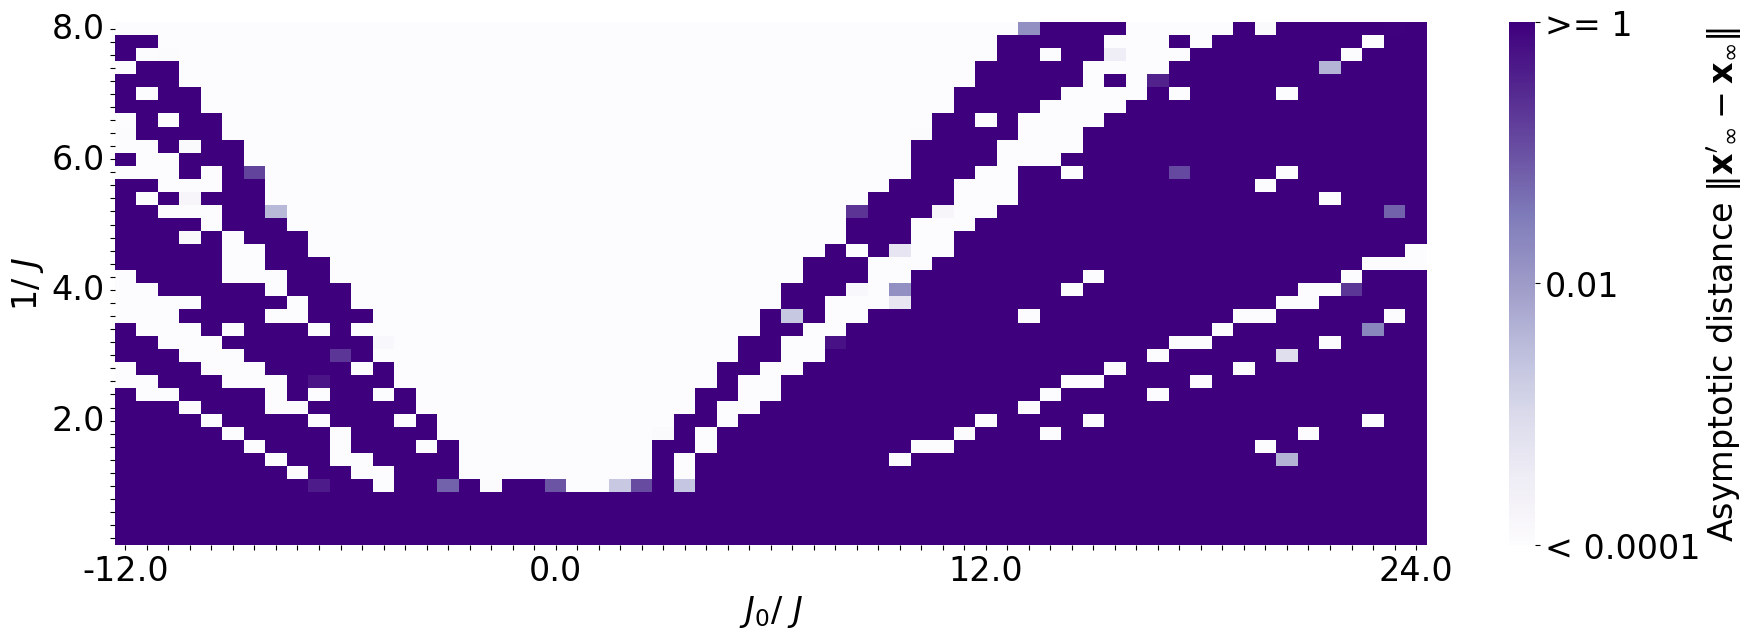

In [20]:
plot_separation(results)

In [21]:
_,bb,cc=prepare_xy(results)
print(bb)
print(cc)


['-12.0', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '0.0', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '12.0', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '24.0']
[[-4.00000000e+00 -3.99618994e+00 -4.00000000e+00 ...  4.34272769e-05
  -2.74913048e-02  4.34272769e-05]
 [ 4.34272769e-05  4.34272769e-05 -4.00000000e+00 ... -3.99752464e+00
   4.34272769e-05  4.34272769e-05]
 [ 4.34272769e-05 -3.99983538e+00 -3.94644081e+00 ...  4.34272769e-05
   4.34272769e-05  4.34272769e-05]
 ...
 [ 4.34272769e-05  4.34272769e-05  4.34272769e-05 ...  4.34272769e-05
   4.34272769e-05  4.34272769e-05]
 [ 4.34272769e-05  4.34272769e-05  4.34272769e-05 ...  4.34272769e-05
   4.34272769e-05  4.34272769e-05]
 [ 4.34272769e-05  4.34272769e-05  4.34272769e-05 ...  4.34272769e-05
   4.34272769e-05  4.34272769e-05]]
